# Nested Latin Hypercube Design — Example

Two algorithms are available:

| Function | Algorithm | Divisibility | Use when |
|----------|-----------|--------------|----------|
| `nested_lhd` | Qian (2009) | n_{i+1} % n_i == 0 | Round sizes, e.g. [10, 20, 40] |
| `nested_maximin_lhd` | Rennen et al. (2010) | (n_{i+1}-1) % (n_i-1) == 0 | Best space-filling, e.g. [2, 3, 5, 9] |

Each returns nested layers where every layer is a valid LHD and each smaller set is a subset of larger ones.

In [1]:
import sys
from pathlib import Path

# # Add project root so "import gethypercube" works when running from the repo
# _root = Path.cwd()
# if (_root / "gethypercube").is_dir():
#     pass
# elif (_root.parent / "gethypercube").is_dir():
#     _root = _root.parent
# if str(_root) not in sys.path:
#     sys.path.insert(0, str(_root))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

%load_ext autoreload
%autoreload 2

from gethypercube import (
    nested_lhd,
    nested_maximin_lhd,
    validate_m_layers_qian,
    validate_m_layers_rennen,
    check_valid_lhd,
    check_nested,
    lhs_degree,
    ks_test_uniform,
    suggest_valid_layers_qian,
    suggest_valid_layers_rennen,
)

plt.rcParams["figure.facecolor"] = "white"


## 1. Valid layer sizes

- **Qian:** n_{i+1} must be divisible by n_i (e.g. [2, 4, 8], [10, 20, 40]).
- **Rennen:** (n_{i+1} - 1) must be divisible by (n_i - 1) (e.g. [2, 3, 5, 9]).

In [2]:
# Qian: [2, 4, 8] — each divides the next
validate_m_layers_qian([2, 4, 8])
print("Qian valid: [2, 4, 8]")

# Rennen: [2, 3, 5, 9] — (n-1) ratios are 2
validate_m_layers_rennen([2, 3, 5, 9])
print("Rennen valid: [2, 3, 5, 9]")

# Invalid for Qian: 30 % 20 != 0
try:
    validate_m_layers_qian([10, 20, 30])
except ValueError as e:
    print(f"Qian invalid [10,20,30]: {e}")

# Invalid for Rennen: (8-1) % (4-1) != 0
try:
    validate_m_layers_rennen([2, 4, 8])
except ValueError as e:
    print(f"Rennen invalid [2,4,8]: {e}")

print("\nSuggest Qian (n_start=2, n_max=50):", suggest_valid_layers_qian(2, 50)[:3])
print("Suggest Rennen (n_start=2, n_max=50):", suggest_valid_layers_rennen(2, 50)[:3])

Qian valid: [2, 4, 8]
Rennen valid: [2, 3, 5, 9]
Qian invalid [10,20,30]: Qian divisibility violated between layers 1 and 2: n_3=30 is not divisible by n_2=20. Ratio = 1.5000. Valid next sizes from 20: [40, 60, 80, 100, 200].
Rennen invalid [2,4,8]: Rennen divisibility violated between layers 1 and 2: (n_3-1)=7 is not divisible by (n_2-1)=3. Ratio = 2.3333. Valid next sizes from 4: [7, 10, 13, 16, 31].

Suggest Qian (n_start=2, n_max=50): [[2, 4, 8, 16, 32], [2, 6, 18], [2, 8, 32]]
Suggest Rennen (n_start=2, n_max=50): [[2, 3, 5, 9, 17, 33], [2, 4, 10, 28], [2, 5, 17]]


## 2. Qian (2009) — `nested_lhd`

Algebraic construction; divisibility n_{i+1} % n_i == 0. Levels {1/n, 2/n, ..., 1}.

In [3]:
# --- Plotting helpers for Qian section ---

def layer_stats(layers):
    """Return list of (lhs_degree, ks_max_stat, ks_min_pval) per layer."""
    out = []
    for X in layers:
        d = lhs_degree(X)
        ks = ks_test_uniform(X)
        max_stat = max(s for s, _ in ks)
        min_pval = min(p for _, p in ks)
        out.append((d, max_stat, min_pval))
    return out

def print_layer_stats(layers, label=""):
    """Print LHS degree and KS stats for each layer."""
    stats = layer_stats(layers)
    print(f"{label}layers: {[L.shape for L in layers]}")
    for i, (d, max_s, min_p) in enumerate(stats):
        print(f"  Layer {i} (n={len(layers[i])}): D={d:.4f}  KS max={max_s:.4f} min_pval={min_p:.4f}")

def plot_nested_scatter(layers, title="Qian (2009)"):
    """Scatter plot: outer layers larger circles, inner on top."""
    fig, ax = plt.subplots(figsize=(5, 5))
    L = len(layers)
    colors = plt.cm.viridis(np.linspace(0.2, 0.85, L))
    sizes = 30 + 30 * (np.arange(L))**2
    for i in range(L - 1, -1, -1):
        X = layers[i]
        ax.scatter(
            X[:, 0], X[:, 1],
            s=sizes[i], c=np.array([colors[i]]), alpha=1, linewidths=1,
            label=f"Layer {i} (n={len(X)})", zorder=L - 1 - i,
        )
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect("equal")
    ax.legend(loc="upper left")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_marginal_uniformity(layers, k, title_prefix="", show_stats=True):
    """One subplot per layer × param: empirical CDF vs U(0,1). Optionally show D and KS on each subplot."""
    n_layers = len(layers)
    stats = layer_stats(layers) if show_stats else None
    fig, ax = plt.subplots(n_layers, k, figsize=(3 * k, 2.5 * n_layers), sharex=True, sharey=True)
    ax = np.atleast_2d(ax)
    if ax.shape[0] == 1 and ax.shape[1] > 1:
        ax = ax.reshape(1, -1)
    elif ax.shape[1] == 1 and ax.shape[0] > 1:
        ax = ax.reshape(-1, 1)
    xx = np.linspace(0, 1, 100)
    for ell, X in enumerate(layers):
        n = len(X)
        for j in range(k):
            a = ax[ell, j]
            sorted_vals = np.sort(X[:, j])
            emp_y = (np.arange(1, n + 1, dtype=float) / n)
            a.plot(sorted_vals, emp_y, color="#2563eb", lw=2, label="Empirical CDF")
            a.plot(xx, xx, color="#9ca3af", lw=1.5, ls="--", label="U(0,1)")
            a.set_xlim(-0.02, 1.02)
            a.set_ylim(-0.02, 1.02)
            a.set_aspect("equal")
            a.grid(True, alpha=0.3)
            title = f"Layer {ell} (n={n}) · $x_{j+1}$"
            if show_stats and stats:
                d, max_s, min_p = stats[ell]
                title += f"\nD={d:.3f} KS={max_s:.3f}"
            a.set_title(title, fontsize=9)
            if j == 0:
                a.set_ylabel("CDF")
            if ell == 0:
                a.legend(loc="lower right", fontsize=8)
    fig.suptitle(f"{title_prefix}Marginal uniformity", fontsize=12, y=1.02)
    plt.setp(ax[-1, :], xlabel="$x$")
    plt.tight_layout()
    plt.show()

Unscrambled layers: [(10, 2), (20, 2), (40, 2)]
  Layer 0 (n=10): D=1.0000  KS max=0.0625 min_pval=1.0000
  Layer 1 (n=20): D=1.0000  KS max=0.0375 min_pval=1.0000
  Layer 2 (n=40): D=1.0000  KS max=0.0125 min_pval=1.0000


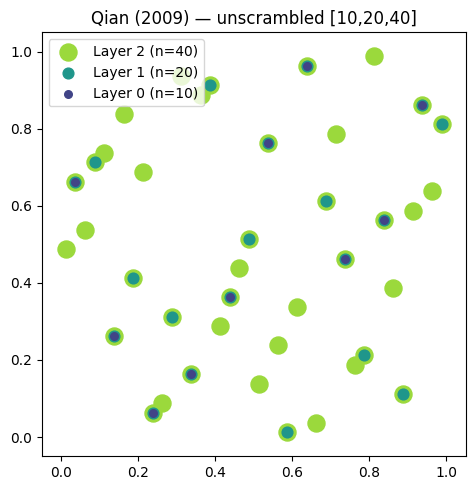

In [4]:
# Small example [10, 20, 40] — unscrambled
k = 2
m_small = [10, 20, 40]
layers_qian_small_unscrambled = nested_lhd(k=k, m_layers=m_small, seed=17, scramble=False)
print_layer_stats(layers_qian_small_unscrambled, "Unscrambled ")
plot_nested_scatter(layers_qian_small_unscrambled, title="Qian (2009) — unscrambled [10,20,40]")

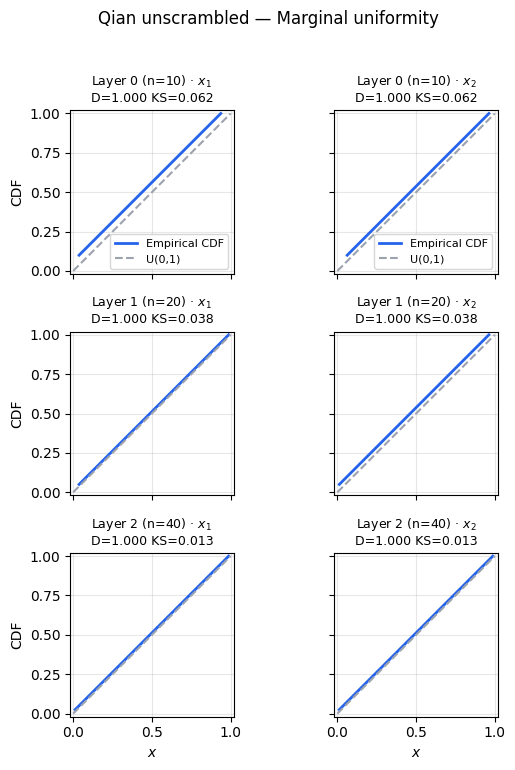

In [5]:
plot_marginal_uniformity(layers_qian_small_unscrambled, k, title_prefix="Qian unscrambled — ")

In [6]:
# Small example [10, 20, 40] — scrambled
layers_qian_small_scrambled = nested_lhd(k=k, m_layers=m_small, seed=17, scramble=True)
print_layer_stats(layers_qian_small_scrambled, "Scrambled ")

Scrambled layers: [(10, 2), (20, 2), (40, 2)]
  Layer 0 (n=10): D=1.0000  KS max=0.0748 min_pval=1.0000
  Layer 1 (n=20): D=1.0000  KS max=0.0497 min_pval=1.0000
  Layer 2 (n=40): D=1.0000  KS max=0.0248 min_pval=1.0000


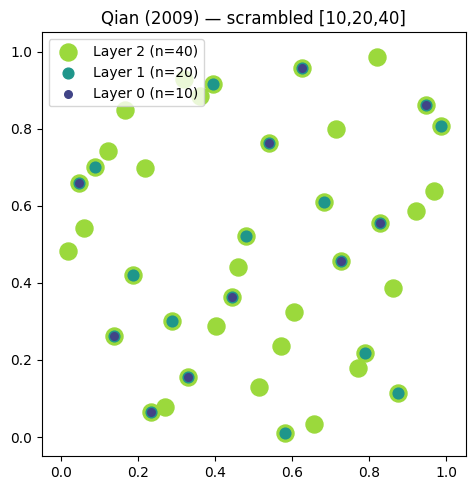

In [7]:
plot_nested_scatter(layers_qian_small_scrambled, title="Qian (2009) — scrambled [10,20,40]")

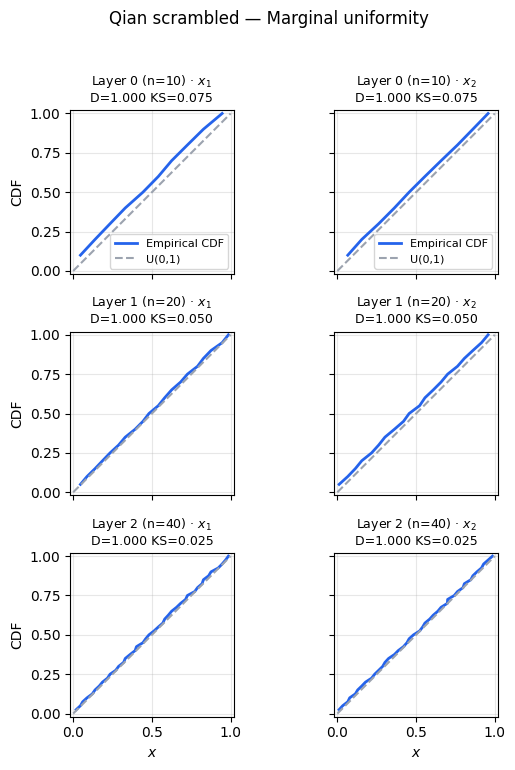

In [8]:
plot_marginal_uniformity(layers_qian_small_scrambled, k, title_prefix="Qian scrambled — ")

### Scipy for comparison

In [9]:
from scipy import stats
layers_qmc = stats.qmc.LatinHypercube(d=k, scramble=False).random(n=40)
print_layer_stats([layers_qmc], "scipy qmc")

scipy qmclayers: [(40, 2)]
  Layer 0 (n=40): D=1.0000  KS max=0.0125 min_pval=1.0000


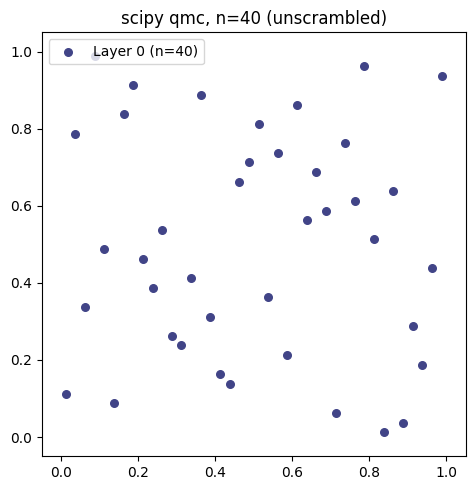

In [10]:
plot_nested_scatter([layers_qmc], title="scipy qmc, n=40 (unscrambled)")

### Large number samples for statistical tests

In [11]:
m_big = [100, 200, 400, 800, 1600]


In [12]:
layers_qian_grid = nested_lhd(k=k, m_layers=m_big, seed=17, scramble=False)
print_layer_stats(layers_qian_grid, "Qian nested (grid)")

Qian nested (grid)layers: [(100, 2), (200, 2), (400, 2), (800, 2), (1600, 2)]
  Layer 0 (n=100): D=1.0000  KS max=0.0059 min_pval=1.0000
  Layer 1 (n=200): D=1.0000  KS max=0.0041 min_pval=1.0000
  Layer 2 (n=400): D=1.0000  KS max=0.0016 min_pval=1.0000
  Layer 3 (n=800): D=1.0000  KS max=0.0009 min_pval=1.0000
  Layer 4 (n=1600): D=1.0000  KS max=0.0003 min_pval=1.0000


Qian nested (scrambled)layers: [(100, 2), (200, 2), (400, 2), (800, 2), (1600, 2)]
  Layer 0 (n=100): D=1.0000  KS max=0.0062 min_pval=1.0000
  Layer 1 (n=200): D=1.0000  KS max=0.0044 min_pval=1.0000
  Layer 2 (n=400): D=1.0000  KS max=0.0019 min_pval=1.0000
  Layer 3 (n=800): D=1.0000  KS max=0.0012 min_pval=1.0000
  Layer 4 (n=1600): D=1.0000  KS max=0.0006 min_pval=1.0000


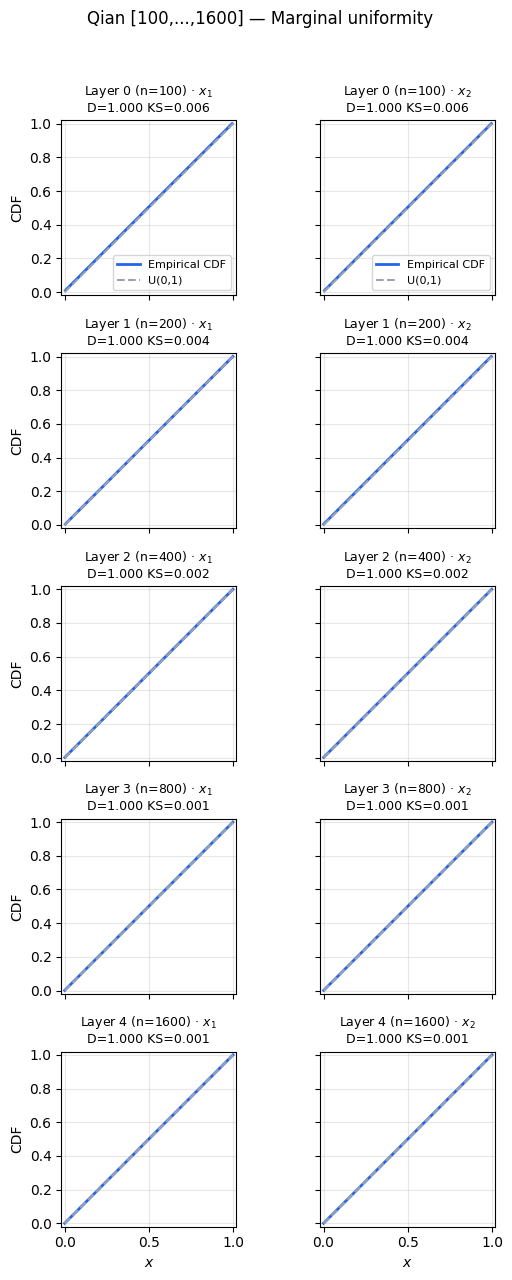

In [13]:
# Bigger example [100, 200, 400, 800, 1600]
layers_qian = nested_lhd(k=k, m_layers=m_big, seed=17, scramble=True)
print_layer_stats(layers_qian, "Qian nested (scrambled)")
plot_marginal_uniformity(layers_qian, k, title_prefix="Qian [100,...,1600] — ")

### Comparison: downsample vs upsample

- **Downsample:** One big LHD of size 1600, then take random subsets of 100, 200, 400, 800, 1600. Compare stats for each size.
- **Upsample:** Build many independent LHDs of size 100, concatenate to get 100 (1×), 200 (2×), 400 (4×), 800 (8×), 1600 (16×). Compare to nested.

Downsample layers: [(100, 2), (200, 2), (400, 2), (800, 2), (1600, 2)]
  Layer 0 (n=100): D=0.6050  KS max=0.1442 min_pval=0.0280
  Layer 1 (n=200): D=0.6675  KS max=0.0626 min_pval=0.3962
  Layer 2 (n=400): D=0.6825  KS max=0.0293 min_pval=0.8718
  Layer 3 (n=800): D=0.7562  KS max=0.0162 min_pval=0.9827
  Layer 4 (n=1600): D=1.0000  KS max=0.0006 min_pval=1.0000


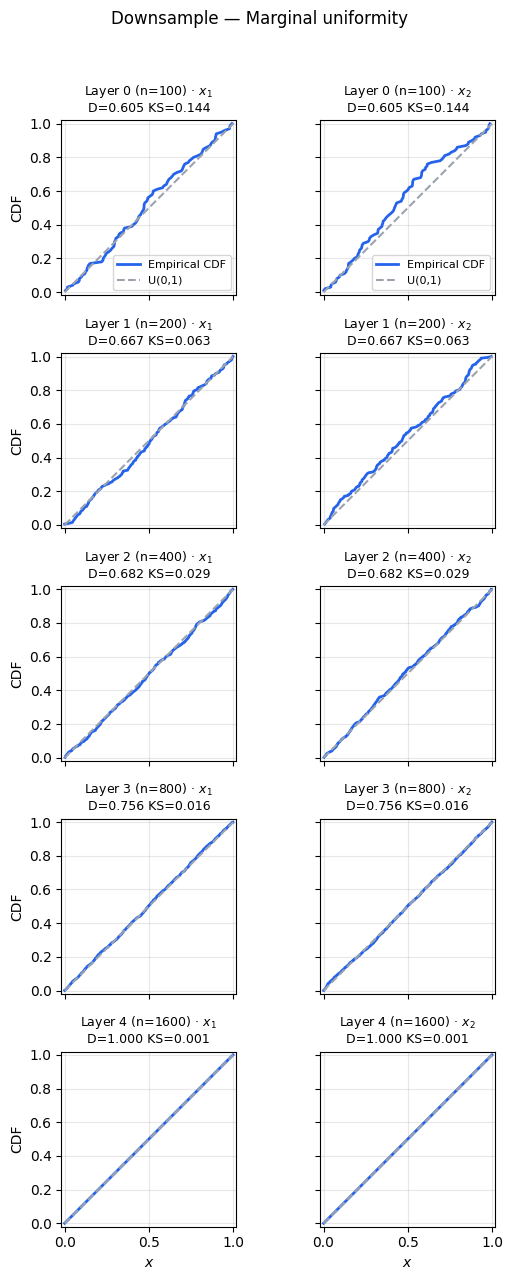

In [14]:
# Downsample: one big LHD of size 1600, cut randomly into subsets of 100, 200, 400, 800, 1600
rng = np.random.default_rng(17)
n_max = 1600
big_lhd = nested_lhd(k=k, m_layers=[n_max], seed=17, scramble=True)[0]
idxs = {}
for n in m_big:
    idxs[n] = rng.choice(n_max, size=n, replace=False)
layers_downsample = [big_lhd[idxs[n]] for n in m_big]
print_layer_stats(layers_downsample, "Downsample ")
plot_marginal_uniformity(layers_downsample, k, title_prefix="Downsample — ")

Upsample layers: [(100, 2), (200, 2), (400, 2), (800, 2), (1600, 2)]
  Layer 0 (n=100): D=1.0000  KS max=0.0100 min_pval=1.0000
  Layer 1 (n=200): D=0.7450  KS max=0.0094 min_pval=1.0000
  Layer 2 (n=400): D=0.6900  KS max=0.0084 min_pval=1.0000
  Layer 3 (n=800): D=0.6469  KS max=0.0067 min_pval=1.0000
  Layer 4 (n=1600): D=0.6481  KS max=0.0039 min_pval=1.0000


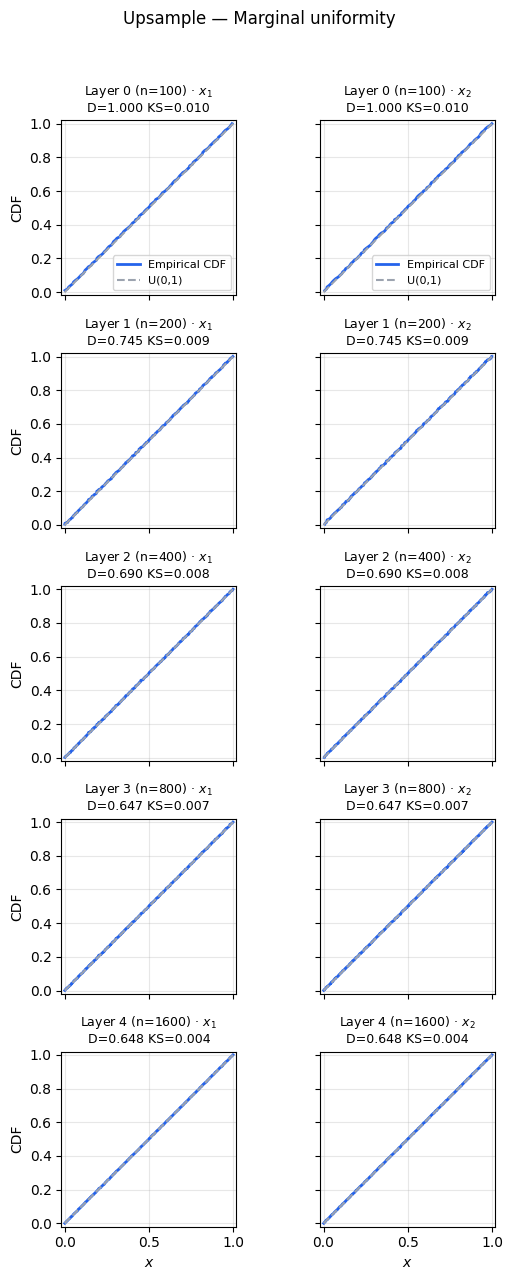

In [15]:
# Upsample: combine many small LHDs (n=100) to make 100, 200, 400, 800, 1600
rng = np.random.default_rng(17)
n_small = 100
# Build 16 independent LHDs of size 100
lhd_100_list = [nested_lhd(k=k, m_layers=[n_small], seed=17 + i, scramble=True)[0] for i in range(16)]
layers_upsample = [
    lhd_100_list[0],
    np.vstack(lhd_100_list[:2]),
    np.vstack(lhd_100_list[:4]),
    np.vstack(lhd_100_list[:8]),
    np.vstack(lhd_100_list[:16]),
]
print_layer_stats(layers_upsample, "Upsample ")
plot_marginal_uniformity(layers_upsample, k, title_prefix="Upsample — ")

In [16]:
# Compare stats for same-size layers: nested vs downsample vs upsample
sizes = m_big  # [100, 200, 400, 800, 1600]
rows = []
for name, layers in [
    ("Qian nested (grid)", layers_qian_grid),
    ("Qian nested (scrambled)", layers_qian),
    ("Downsample", layers_downsample),
    ("Upsample", layers_upsample),
]:
    stats = layer_stats(layers)
    for i, (n, (d, max_s, min_p)) in enumerate(zip(sizes, stats)):
        rows.append({"Method": name, "n": n, "D": d, "KS_max": max_s, "KS_min_pval": min_p})
df = pd.DataFrame(rows)
df

# Pivot by n for direct comparison
df.pivot(index="n", columns="Method", values=["D", "KS_max"])

D                                                       \
Method Downsample Qian nested (grid) Qian nested (scrambled)  Upsample   
n                                                                        
100       0.60500                1.0                     1.0  1.000000   
200       0.66750                1.0                     1.0  0.745000   
400       0.68250                1.0                     1.0  0.690000   
800       0.75625                1.0                     1.0  0.646875   
1600      1.00000                1.0                     1.0  0.648125   

           KS_max                                                       
Method Downsample Qian nested (grid) Qian nested (scrambled)  Upsample  
n                                                                       
100      0.144225           0.005938                0.006246  0.009975  
200      0.062643           0.004063                0.004375  0.009427  
400      0.029311           0.001563                0.001875  0.008369  
800      0.016185           0.000938                0.001249  0.006693  
1600     0.000625           0.000313                0.000625  0.003869

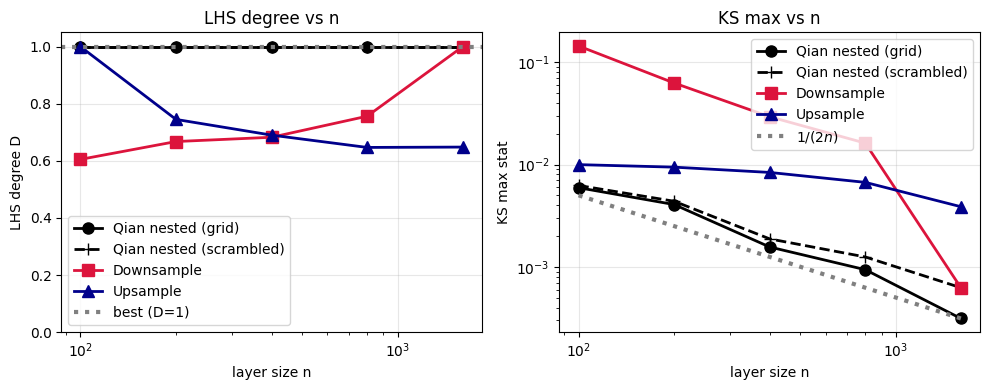

In [17]:
# Stats vs layer size: Qian vs downsample vs upsample
from matplotlib.cbook import ls_mapper_r


fig, (ax_d, ax_ks) = plt.subplots(1, 2, figsize=(10, 4))
n_plot = np.array(m_big)

for name, color, marker, ls in [
    ("Qian nested (grid)", "black", "o", "-"),
    ("Qian nested (scrambled)", "black", "+", "--"),
    ("Downsample", "crimson", "s", "-"),
    ("Upsample", "darkblue", "^", "-"),
]:
    rows = df[df["Method"] == name]
    ax_d.plot(rows["n"], rows["D"], color=color, marker=marker, label=name, lw=2, ls=ls, markersize=8)
    ax_ks.plot(rows["n"], rows["KS_max"], color=color, marker=marker, label=name, lw=2, ls=ls, markersize=8)

# Best/reference lines: D = 1 (best), KS = 1/(2n) (expected scale)
ax_d.axhline(1.0, color="gray", ls=":", lw=3, label="best (D=1)")
ax_d.set_ylabel("LHS degree D")
ax_d.set_xlabel("layer size n")
ax_d.set_title("LHS degree vs n")
ax_d.legend()
ax_d.set_xscale("log")
ax_d.set_ylim(0, 1.05)
ax_d.grid(True, alpha=0.3)

n_ref = np.logspace(np.log10(np.min(n_plot)), np.log10(np.max(n_plot)), 200)  # 100 to 10000 for smooth curve
ax_ks.plot(n_ref, 1 / (2 * n_ref), color="gray", ls=":", lw=3, label=r"$1/(2n)$")
ax_ks.set_ylabel("KS max stat")
ax_ks.set_xlabel("layer size n")
ax_ks.set_title("KS max vs n")
ax_ks.legend()
ax_ks.set_xscale("log")
ax_ks.set_yscale("log")
ax_ks.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Rennen et al. (2010) — `nested_maximin_lhd`

ESE-optimised maximin design; divisibility (n_{i+1}-1) % (n_i-1) == 0. Levels {0, 1/(n-1), ..., 1}.

In [18]:
# m_init=10, ratio=2, n_layers=3 → m_layers = [10, 19, 37]
start = time.time()
layers_rennen = nested_maximin_lhd(
    k=2, m_init=10, n_layers=3, ratio=2, seed=123, n_restarts=2, max_outer_iters=25
)
end = time.time()
print(f"Time taken: {end - start} seconds")

print("Rennen layers:", [L.shape for L in layers_rennen])
for i, L in enumerate(layers_rennen):
    print(f"  Layer {i} valid LHD (rennen): {check_valid_lhd(L, convention='rennen')}")
for i, L in enumerate(layers_rennen):
    d = lhs_degree(L)
    ks = ks_test_uniform(L)
    max_stat = max(s for s, _ in ks)
    min_pval = min(p for _, p in ks)
    print(f"  Layer {i} LHS degree D: {d:.4f}  KS max_stat={max_stat:.4f} min_pval={min_pval:.4f}")
for i in range(len(layers_rennen) - 1):
    print(f"  Layer {i} ⊂ Layer {i+1}: {check_nested(layers_rennen[i], layers_rennen[i+1])}")

Time taken: 60.965134143829346 seconds
Rennen layers: [(10, 2), (19, 2), (37, 2)]
  Layer 0 valid LHD (rennen): False
  Layer 1 valid LHD (rennen): False
  Layer 2 valid LHD (rennen): False
  Layer 0 LHS degree D: 1.0000  KS max_stat=0.0984 min_pval=0.9997
  Layer 1 LHS degree D: 1.0000  KS max_stat=0.0511 min_pval=1.0000
  Layer 2 LHS degree D: 1.0000  KS max_stat=0.0269 min_pval=1.0000
  Layer 0 ⊂ Layer 1: True
  Layer 1 ⊂ Layer 2: True


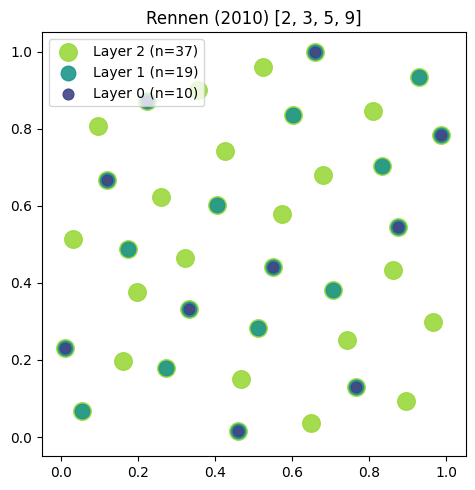

In [19]:
# One figure per algorithm: outer layers = larger circles (drawn first), inner = smaller (on top)
fig, ax = plt.subplots(figsize=(5, 5))
L = len(layers_rennen)
colors = plt.cm.viridis(np.linspace(0.2, 0.85, L))  # inner = dark, outer = light
sizes = 60 + 50 * np.arange(L)  # inner = smaller, outer = larger
for i in range(L - 1, -1, -1):  # draw outer first, inner last (on top)
    X = layers_rennen[i]
    ax.scatter(
        X[:, 0], X[:, 1],
        s=sizes[i], c=np.array([colors[i]]), alpha=0.9, linewidths=1,
        label=f"Layer {i} (n={len(X)})", zorder=L - 1 - i,
    )
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_aspect("equal")
ax.legend(loc="upper left")
ax.set_title("Rennen (2010) [2, 3, 5, 9]")
plt.tight_layout()
plt.show()

**Marginal uniformity (Rennen)** — Same CDF comparison. Smaller-n layers can sit off the diagonal for the same reason as Qian: they use a subset of the full grid so the step positions need not match the continuous U(0,1) diagonal.

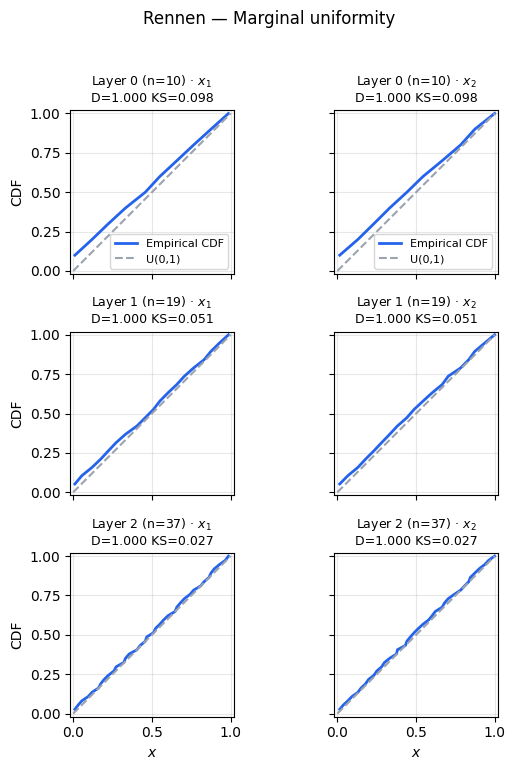

In [20]:
k_rennen = layers_rennen[0].shape[1]
plot_marginal_uniformity(layers_rennen, k_rennen, title_prefix="Rennen — ")